In [ ]:
!pip install google_play_scraper
!pip install textblob
from google_play_scraper import app
import pandas as pd
import numpy as np
import sklearn
import requests
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import textblob
#from wordcloud import WordCloud
from pathlib import Path
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score

import pickle
import re
import time
import datetime                              # access to %%time, for timing individual notebook cells
import os
from PIL import Image
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

%matplotlib inline
%config InlineBackend.figure_format='retina'

plt.style.use('seaborn')
plt.rcParams["figure.figsize"] = (15,10)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 794.5 kB/s eta 0:00:00


<ipython-input-1-9ccb641008d5>:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [ ]:
#Android App YesDok link from Google Play at
#https://play.google.com/store/apps/details?id=com.yesdok.mobile.app&hl=id
#The apps ID found in the link after id=com.yesdok.mobile.app&hl=id
#The apps name on Google Play titled: YesDok by YesDok
#Dated 8 September 2024: number of reviews 16k

from google_play_scraper import app, Sort, reviews_all

yesdok_reviews = reviews_all(
    'com.yesdok.mobile.app',
    sleep_milliseconds=0, # defaults to 0
    lang='id', # defaults to 'en'
    sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
)

In [ ]:
#Save the YesDok app reviews into dataframe
df_yesdokrev = pd.DataFrame(np.array(yesdok_reviews),columns=['content'])
df_yesdokrev = df_yesdokrev.join(pd.DataFrame(df_yesdokrev.pop('content').tolist()))
df_yesdokrev.to_csv(r'review_yesdok_raw.csv', index=False)
df_yesdokrev.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,2bb04eab-717b-4055-9db7-f38ef60ecba0,Debby Sintia,https://play-lh.googleusercontent.com/a-/ALV-U...,"Gak bisa bayar yg mau di bpilih , bingung aneh...",2,0,12.2.4,2024-07-15 09:19:36,None,NaT,12.2.4
1,d3e5d6bb-3994-4e78-986c-031f8f03f1f2,Pangersa Sayyid Baher Albantani,https://play-lh.googleusercontent.com/a-/ALV-U...,Sgt berguna utk tahu kesehatan dan shared soal...,5,0,12.2.4,2024-07-14 16:08:45,None,NaT,12.2.4
2,d9600cfa-93c1-4c85-9884-0adc5002d9d4,Puji Wulandari,https://play-lh.googleusercontent.com/a-/ALV-U...,Sudah war jadwal dokter berbulan2 pas hari H d...,1,0,12.2.3,2024-07-02 08:11:52,None,NaT,12.2.3
3,394f32b5-40b6-4bf6-be29-f04a9b8d2f81,Restu Hendri Sulistyawan,https://play-lh.googleusercontent.com/a/ACg8oc...,Dokternya sibuk terus,1,0,12.2.1,2024-05-17 05:37:42,None,NaT,12.2.1
4,ad828567-8e95-46e5-bada-04cbf442c946,Dita Nilawati,https://play-lh.googleusercontent.com/a/ACg8oc...,Aplikasi yang sangat kurang relevan buat dipak...,1,0,None,2024-05-04 00:07:21,None,NaT,None


In [ ]:
#Information on the table
df_yesdokrev.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11676 entries, 0 to 11675
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              11676 non-null  object        
 1   userName              11676 non-null  object        
 2   userImage             11676 non-null  object        
 3   content               11676 non-null  object        
 4   score                 11676 non-null  int64         
 5   thumbsUpCount         11676 non-null  int64         
 6   reviewCreatedVersion  6701 non-null   object        
 7   at                    11676 non-null  datetime64[ns]
 8   replyContent          939 non-null    object        
 9   repliedAt             939 non-null    datetime64[ns]
 10  appVersion            6701 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 1003.5+ KB


In [ ]:
print(df_yesdokrev.reviewCreatedVersion.unique())
print(df_yesdokrev.reviewCreatedVersion.nunique())

['12.2.4' '12.2.3' '12.2.1' None '12.1.3' '12.2.0' '11.2.5' '11.2.3'
 '11.2.1' '11.2.0' '11.1.6' '11.1.5' '11.1.3' '11.1.2' '11.1.1' '11.1.0'
 '11.0.9' '11.0.8' '11.0.7' '11.0.5' '11.0.4' '11.0.3' '11.0.2' '9.2.8'
 '11.0.1' '11.0.0' '10.1.1' '10.0.25' '10.0.16' '10.0.23' '10.0.20'
 '10.0.18' '10.0.12' '10.0.9' '10.0.11' '10.0.10' '10.0.7' '10.0.6'
 '10.0.5' '9.5.5' '9.5.4' '9.5.3' '9.5.2' '9.5.1' '9.2.1' '9.5.0' '9.4.5'
 '9.4.9' '9.4.8' '9.4.7' '9.4.6' '9.4.3' '9.3.3' '9.4.4' '9.3.2' '9.4.2'
 '9.4.1' '9.4.0' '9.3.8' '8.2.9' '9.3.1' '8.3.0' '9.2.4' '9.3.0' '9.2.9'
 '9.2.7' '9.2.5' '9.2.6' '9.2.3' '9.2.0' '8.3.4' '9.1.9' '9.1.8' '9.1.7'
 '9.1.5' '9.1.4' '9.1.6' '9.1.3' '9.1.2' '9.1.0' '9.0.9' '9.0.8' '8.4.3'
 '9.0.7' '9.0.6' '9.0.5' '9.0.4' '9.0.1' '9.0.3' '9.0.2' '9.0.0av' '8.4.2'
 '8.3.9' '8.3.8' '8.4.1' '8.3.7' '8.3.6' '8.3.3b' '8.3.2' '8.2.4' '8.2.8'
 '5.3.4' '8.2.6' '8.2.0' '8.2.7' '5.0.9' '7.4.6' '8.2.3' '8.2.2' '8.2.1'
 '8.1.9' '7.3.9' '8.1.8' '8.1.6' '8.1.1' '8.1.5' '8.1.4' '8.0.

In [ ]:
#We do not need data for column reviewId, userName, userImage so
#we will show only these column
df_yesdokrev.loc[:,["content","score","thumbsUpCount", "reviewCreatedVersion", "at", "replyContent", "repliedAt"]]

,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,"Gak bisa bayar yg mau di bpilih , bingung aneh...",2,0,12.2.4,2024-07-15 09:19:36,None,NaT
1,Sgt berguna utk tahu kesehatan dan shared soal...,5,0,12.2.4,2024-07-14 16:08:45,None,NaT
2,Sudah war jadwal dokter berbulan2 pas hari H d...,1,0,12.2.3,2024-07-02 08:11:52,None,NaT
3,Dokternya sibuk terus,1,0,12.2.1,2024-05-17 05:37:42,None,NaT
4,Aplikasi yang sangat kurang relevan buat dipak...,1,0,None,2024-05-04 00:07:21,None,NaT
...,...,...,...,...,...,...,...
11671,Sangat membantu.. Aplikasinya sangat bagus,5,0,None,2018-01-03 08:14:31,None,NaT
11672,Sangat membantu dalam konsultasi masalah keseh...,5,2,2.10,2017-12-23 15:32:57,None,NaT
11673,Bagus,5,0,None,2017-12-12 09:36:43,None,NaT
11674,Helpfully,5,2,1.0.7,2017-11-08 08:17:58,None,NaT


In [ ]:
!pip install emoji

import numpy as np
import pandas as pd
pd.set_option("display.max_colwidth", 200)
#from pandas_profiling import ProfileReport
import regex
import nltk
import wordcloud
import textblob

from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob

import string
import re
import emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.2/553.2 kB 3.8 MB/s eta 0:00:00


In [ ]:
#Creating polarity on the column: content (review from the apps) using TextBlob
#Read https://textblob.readthedocs.io/en/dev/quickstart.html

from textblob import TextBlob
df_yesdokrev['sentiment_polarity'] = df_yesdokrev['content'].apply(lambda x: TextBlob(x).polarity)
df_yesdokrev['sentiment_subjective'] = df_yesdokrev['content'].apply(lambda x: TextBlob(x).subjectivity)

In [ ]:
#df_yesdokrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","at"]]
df_yesdokrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective"]]

,content,score,sentiment_polarity,sentiment_subjective
0,"Gak bisa bayar yg mau di bpilih , bingung aneh gak ada bantuan sma sekali",2,0.0,0.0
1,Sgt berguna utk tahu kesehatan dan shared soal kesehatan,5,0.0,0.0
2,Sudah war jadwal dokter berbulan2 pas hari H dokternya terkendala jaringan. Alhasil uang direfund masuk saldo yesdok dan jika ditf ke rekening ada potongan 10k.. yang rugi siapa di sini ? Konsul g...,1,0.2,0.2
3,Dokternya sibuk terus,1,0.0,0.0
4,"Aplikasi yang sangat kurang relevan buat dipake karena pelayanan dari pihak yesdok sendiri kurang baik kurang bermanfaat.saya sangat kecewa,marah karena saya sudah transfer lewat BCA Dan berhasil ...",1,0.0,0.0
...,...,...,...,...
11671,Sangat membantu.. Aplikasinya sangat bagus,5,0.0,0.0
11672,Sangat membantu dalam konsultasi masalah kesehatan dengan bertatap lngsung pada dokter via vcall,5,0.0,0.0
11673,Bagus,5,0.0,0.0
11674,Helpfully,5,0.0,0.0


In [ ]:
#Check number of reviews scores
df_yesdokrev['score'].value_counts()

,count
score,
5,11157
4,230
3,124
1,118
2,47


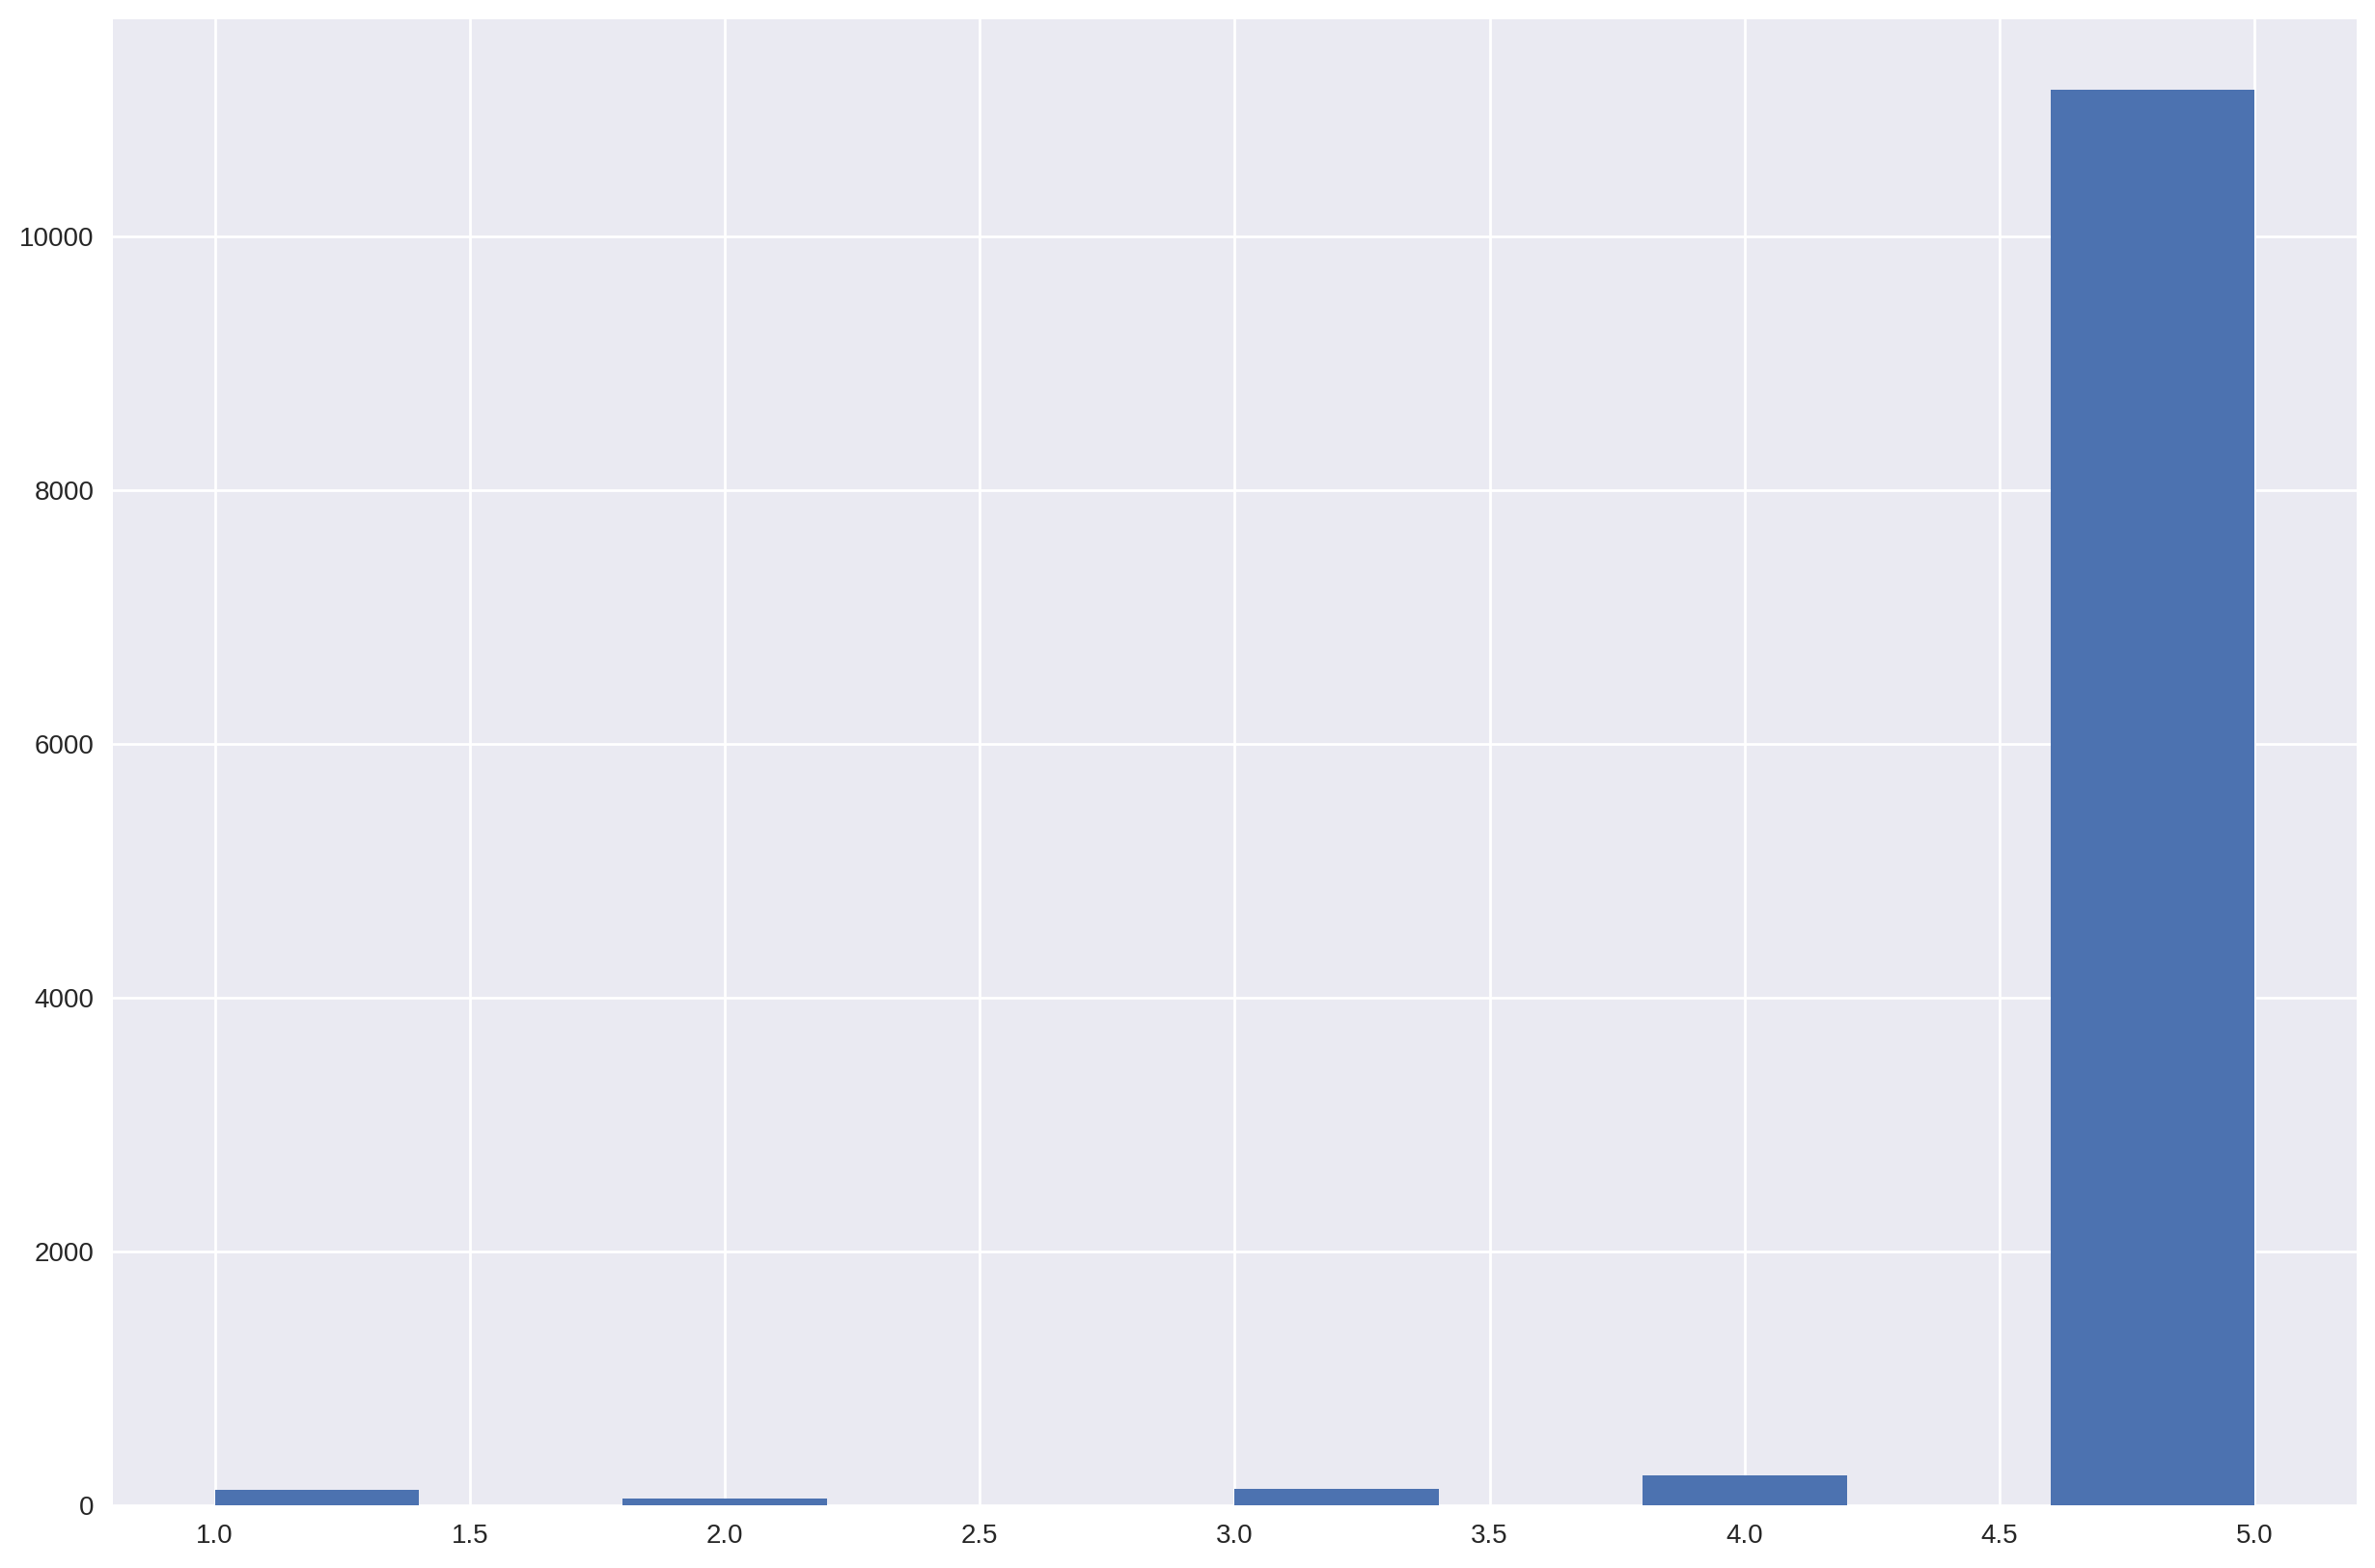

In [ ]:
plt.hist(df_yesdokrev['score'])
plt.show()

In [ ]:
#DATA PREPROCESSING
# Lower casing

# Change the reviews type to string
df_yesdokrev['content'] = df_yesdokrev['content'].astype(str)# Before lowercasing
# Before lowercasing
print(df_yesdokrev['content'][1766])

Cara nebus obatnya gimana yh?


In [ ]:
#Lowercase all reviews to see the difference
df_yesdokrev['content']= df_yesdokrev['content'].apply(lambda x: x.lower())
print(df_yesdokrev['content'][1766])

cara nebus obatnya gimana yh?


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#edited from https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products
import string

df_yesdokrev['wordCount'] = [len(review.split()) for review in df_yesdokrev['content']]

df_yesdokrev['uppercaseCharCount'] = [sum(char.isupper() for char in review) \
                              for review in df_yesdokrev['content']]

df_yesdokrev['specialCharCount'] = [sum(char in string.punctuation for char in review) \
                            for review in df_yesdokrev['content']]

In [ ]:
df_yesdokrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
0,"gak bisa bayar yg mau di bpilih , bingung aneh gak ada bantuan sma sekali",2,0.0,0.0,15,0,1
1,sgt berguna utk tahu kesehatan dan shared soal kesehatan,5,0.0,0.0,9,0,0
2,sudah war jadwal dokter berbulan2 pas hari h dokternya terkendala jaringan. alhasil uang direfund masuk saldo yesdok dan jika ditf ke rekening ada potongan 10k.. yang rugi siapa di sini ? konsul g...,1,0.2,0.2,60,0,13
3,dokternya sibuk terus,1,0.0,0.0,3,0,0
4,"aplikasi yang sangat kurang relevan buat dipake karena pelayanan dari pihak yesdok sendiri kurang baik kurang bermanfaat.saya sangat kecewa,marah karena saya sudah transfer lewat bca dan berhasil ...",1,0.0,0.0,73,0,6
...,...,...,...,...,...,...,...
11671,sangat membantu.. aplikasinya sangat bagus,5,0.0,0.0,5,0,2
11672,sangat membantu dalam konsultasi masalah kesehatan dengan bertatap lngsung pada dokter via vcall,5,0.0,0.0,13,0,0
11673,bagus,5,0.0,0.0,1,0,0
11674,helpfully,5,0.0,0.0,1,0,0


In [ ]:
#Removing stopwords
#Using nltk
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, sent_tokenize
from nltk import FreqDist
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from string import punctuation

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

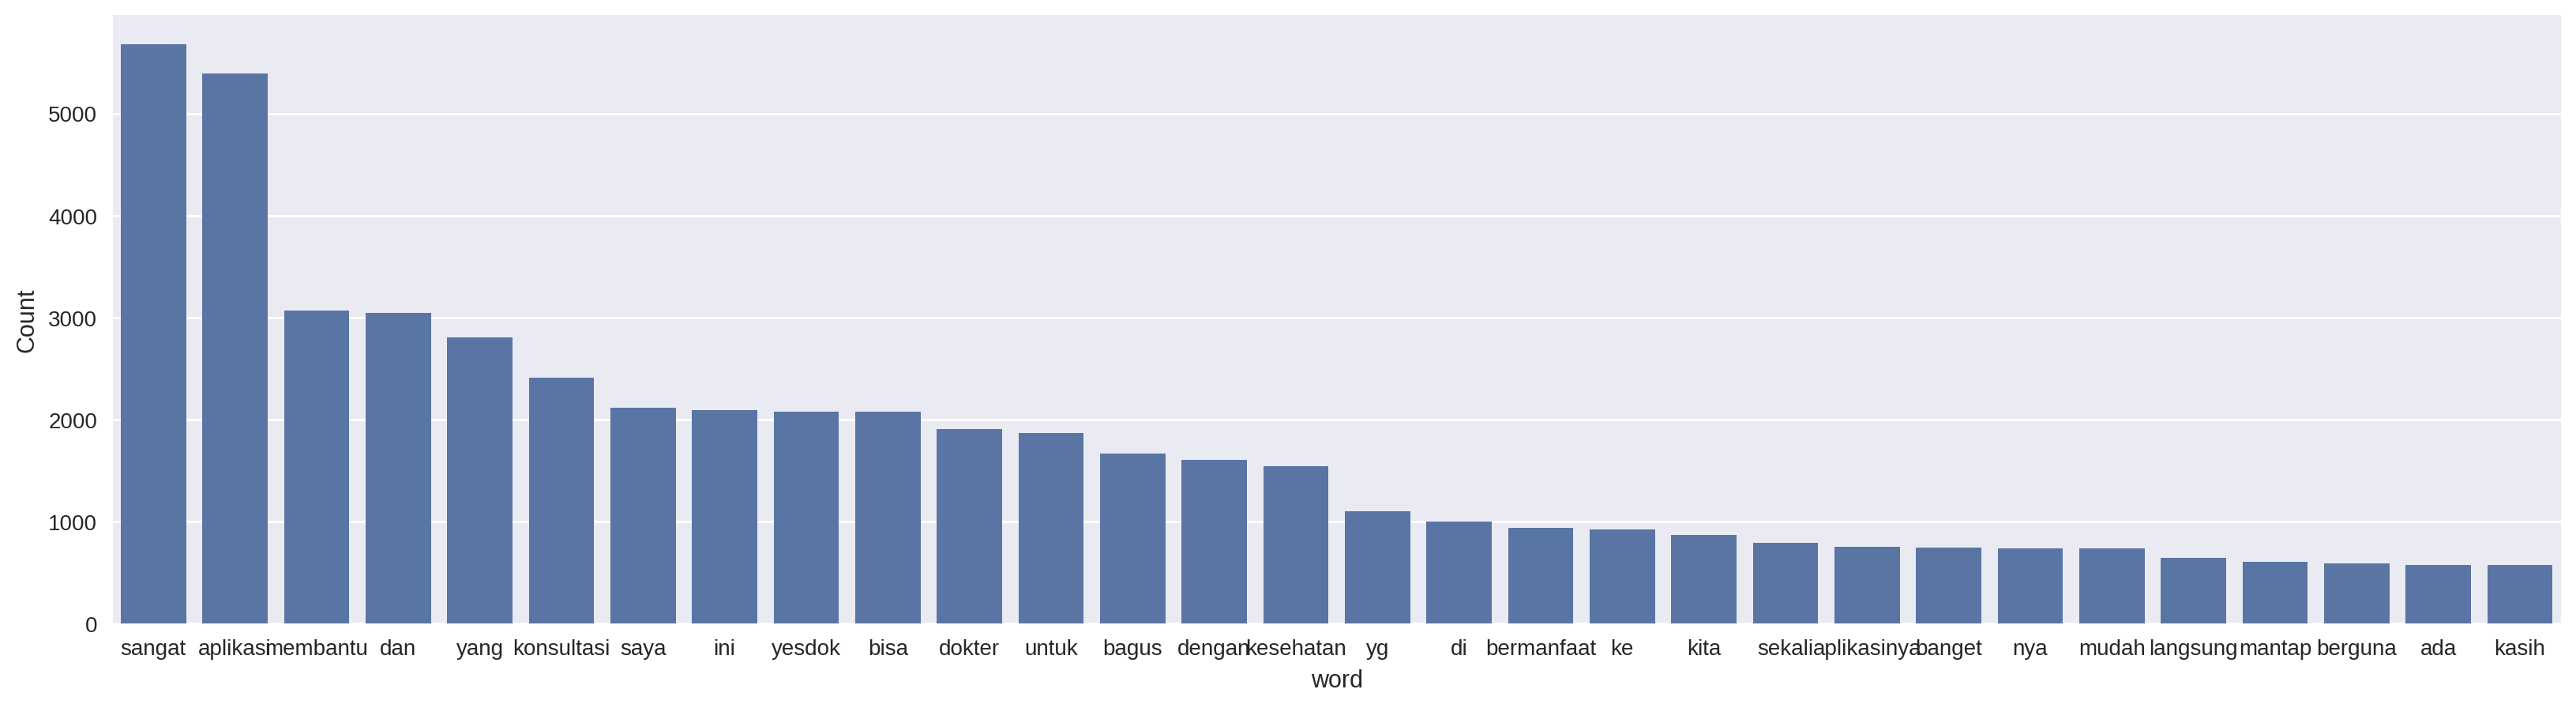

In [ ]:
freq_words(df_yesdokrev['content'])

In [ ]:
#check if there is any special character
alphabet = string.ascii_letters+string.punctuation
print(df_yesdokrev.content.str.strip(alphabet).astype(bool).any())

extracted_emojis=[]

def extract_emojis(s):
    expe = re.compile('[\U00010000-\U0010ffff]', flags=re.UNICODE)
    return expe.findall(s)
    return expe.sub(r'',s)

for y in df_yesdokrev['content']:
    #print(str(extract_emojis(y)))
    extracted_emojis.append(str(extract_emojis(y)))

print(extracted_emojis)

True
['[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['🙏', '🙏', '😁']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['😇', '😇', '😇']", "['👍']", '[]', '[]', "['😠', '😠', '😠', '😠', '😡', '😡', '😡', '😡']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['👍', '👍']", '[]', '[]', '[]', "['🙏']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['😉']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['🥰', '🥰']", '[]', '[]', "['👍']", "['👍']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['👍']", "['😁']", '[]', '[]', '[]', '[]', "['👍', '🏻']", '[]', "['🥺', '🤲', '🕊']", '[]', "['👍', '👍']", '[]', '[]', '[]', "['🥰']", "['🥰']", '[]', '[]', '[]', '[]', "['😘', '😘']", '[]', '[]', '[]', "['🥰']", '[]', '[]', "['😭', '🥳', '👏', '🤩', '🙏', '🥰']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['👍', '💖']", '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', '[]', "['🥺', '🙄', '🙄', '🙄']", '[]', '[]', '[]', '[]', '[]', '

In [ ]:
df_yesdokrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","wordCount","uppercaseCharCount","specialCharCount"]]

,content,score,sentiment_polarity,sentiment_subjective,wordCount,uppercaseCharCount,specialCharCount
0,"gak bisa bayar yg mau di bpilih , bingung aneh gak ada bantuan sma sekali",2,0.0,0.0,15,0,1
1,sgt berguna utk tahu kesehatan dan shared soal kesehatan,5,0.0,0.0,9,0,0
2,sudah war jadwal dokter berbulan2 pas hari h dokternya terkendala jaringan. alhasil uang direfund masuk saldo yesdok dan jika ditf ke rekening ada potongan 10k.. yang rugi siapa di sini ? konsul g...,1,0.2,0.2,60,0,13
3,dokternya sibuk terus,1,0.0,0.0,3,0,0
4,"aplikasi yang sangat kurang relevan buat dipake karena pelayanan dari pihak yesdok sendiri kurang baik kurang bermanfaat.saya sangat kecewa,marah karena saya sudah transfer lewat bca dan berhasil ...",1,0.0,0.0,73,0,6
...,...,...,...,...,...,...,...
11671,sangat membantu.. aplikasinya sangat bagus,5,0.0,0.0,5,0,2
11672,sangat membantu dalam konsultasi masalah kesehatan dengan bertatap lngsung pada dokter via vcall,5,0.0,0.0,13,0,0
11673,bagus,5,0.0,0.0,1,0,0
11674,helpfully,5,0.0,0.0,1,0,0


In [ ]:
#Add a column name polarity_rating from changing the score of the review into 3 labels: Pos, Negative Neutral
df_yesdokrev['sentiment_rating'] = df_yesdokrev['score'].apply(lambda x: 'Positive' if x > 3 else('Neutral' if x == 3  else 'Negative'))

In [ ]:
df_yesdokrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

,content,score,sentiment_polarity,sentiment_subjective,sentiment_rating
0,"gak bisa bayar yg mau di bpilih , bingung aneh gak ada bantuan sma sekali",2,0.0,0.0,Negative
1,sgt berguna utk tahu kesehatan dan shared soal kesehatan,5,0.0,0.0,Positive
2,sudah war jadwal dokter berbulan2 pas hari h dokternya terkendala jaringan. alhasil uang direfund masuk saldo yesdok dan jika ditf ke rekening ada potongan 10k.. yang rugi siapa di sini ? konsul g...,1,0.2,0.2,Negative
3,dokternya sibuk terus,1,0.0,0.0,Negative
4,"aplikasi yang sangat kurang relevan buat dipake karena pelayanan dari pihak yesdok sendiri kurang baik kurang bermanfaat.saya sangat kecewa,marah karena saya sudah transfer lewat bca dan berhasil ...",1,0.0,0.0,Negative
...,...,...,...,...,...
11671,sangat membantu.. aplikasinya sangat bagus,5,0.0,0.0,Positive
11672,sangat membantu dalam konsultasi masalah kesehatan dengan bertatap lngsung pada dokter via vcall,5,0.0,0.0,Positive
11673,bagus,5,0.0,0.0,Positive
11674,helpfully,5,0.0,0.0,Positive


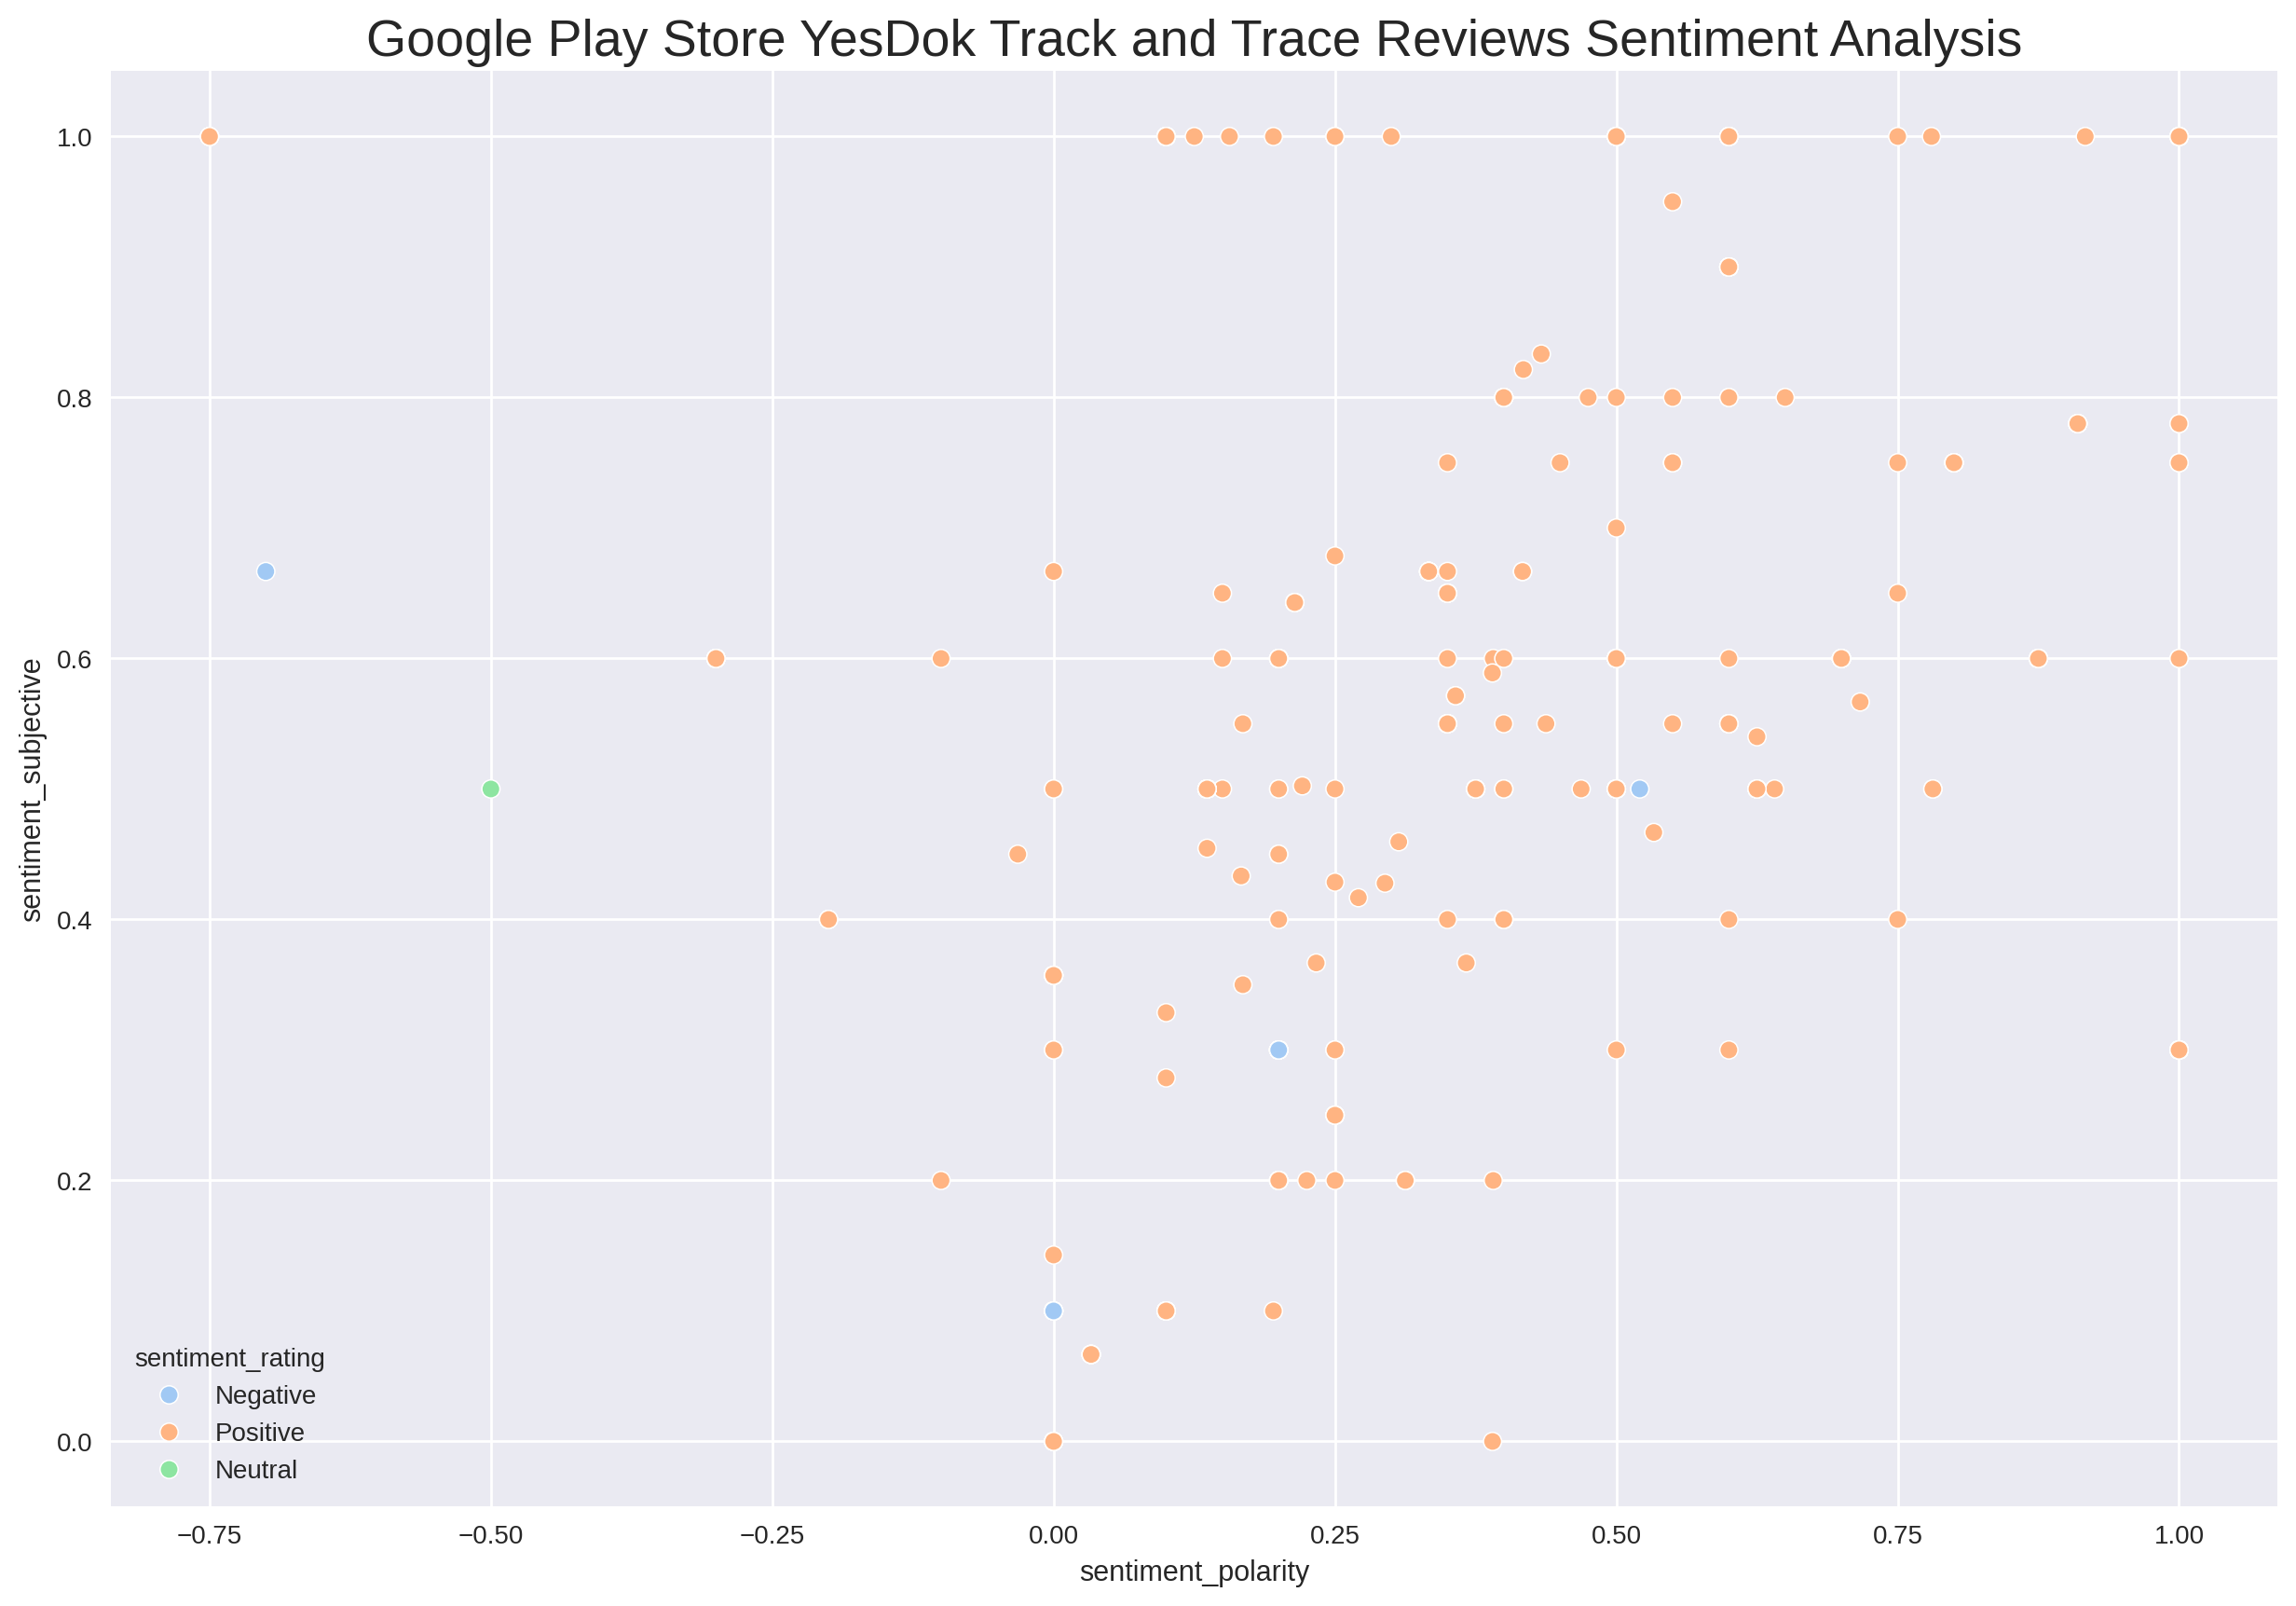

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize=(15, 10))
# sns.scatterplot(df_yesdokrev['sentiment_polarity'], df_yesdokrev['sentiment_subjective'],
#                 hue = df_yesdokrev['sentiment_rating'], edgecolor='white', palette="pastel")
# plt.title("Google Play Store YesDok Track and Trace Reviews Sentiment Analysis", fontsize=20)
# plt.show()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 10))

# Use the 'data' argument to pass the DataFrame and specify 'x' and 'y' within the function call
sns.scatterplot(data=df_yesdokrev, x='sentiment_polarity', y='sentiment_subjective',
                hue='sentiment_rating', edgecolor='white', palette="pastel")

plt.title("Google Play Store YesDok Track and Trace Reviews Sentiment Analysis", fontsize=20)
plt.show()

In [ ]:
#Print the extracted emojis review column (content) before stopwords
df_yesdokrev.to_csv(r'review_yesdok_preprocessed.csv', index = False)

In [ ]:
import nltk
from nltk.corpus import stopwords
stop = set(stopwords.words('indonesian') + ["'", "yg", "nya", ",", "aja", "ya", "orang", "download", "banget", "bgt", "sih"])
print(stop)

{'inginkah', 'agar', 'beginian', 'lebih', 'memulai', 'tentang', 'mengatakannya', 'mengapa', 'lagi', 'mendatangi', 'mempergunakan', 'bisa', 'tandasnya', 'dimaksud', 'setinggi', 'toh', 'lainnya', 'bisakah', 'seseorang', 'aku', 'sepantasnyalah', 'tuturnya', 'akulah', 'begini', 'itu', 'pernah', 'wong', 'perlukah', 'meski', 'ditanya', 'jadinya', 'bagian', 'setempat', 'mengenai', 'merekalah', 'semasa', 'diakhirinya', 'paling', 'mungkinkah', 'dipastikan', 'sela', 'dipertanyakan', 'memastikan', 'semua', 'kamulah', 'banyak', 'diakhiri', 'mempersoalkan', 'agak', 'menanyakan', 'sampai-sampai', 'kita', 'selain', 'mengerjakan', 'bulan', 'kecil', 'hampir', 'itulah', 'bertanya', 'jauh', 'janganlah', 'menggunakan', 'seterusnya', 'tahu', 'tiga', 'jangankan', 'berapakah', 'memungkinkan', 'diketahui', 'ibaratkan', 'menanti', 'sepantasnya', 'tampak', 'tentulah', 'berawal', 'kami', 'berlebihan', 'juga', 'di', 'itukah', 'orang', 'mana', 'selamanya', 'menjadi', 'minta', 'beberapa', 'jadi', 'belakang', 'se', 

In [ ]:
print(len(stop))

768


In [ ]:
df_yesdokrev_stopwords = df_yesdokrev.loc[:,["content","score","sentiment_polarity", "sentiment_subjective","sentiment_rating"]]

In [ ]:
# Exclude stopwords
df_yesdokrev_stopwords['tweet_without_stopwords'] = df_yesdokrev_stopwords['content'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
print(df_yesdokrev_stopwords)

                                                                                                                                                                                                       content  \
0                                                                                                                                    gak bisa bayar yg mau di bpilih , bingung aneh gak ada bantuan sma sekali   
1                                                                                                                                                     sgt berguna utk tahu kesehatan dan shared soal kesehatan   
2      sudah war jadwal dokter berbulan2 pas hari h dokternya terkendala jaringan. alhasil uang direfund masuk saldo yesdok dan jika ditf ke rekening ada potongan 10k.. yang rugi siapa di sini ? konsul g...   
3                                                                                                                                                               

In [ ]:
pat = r'\b(?:{})\b'.format('|'.join(stop))
df_yesdokrev_stopwords['tweet_without_stopwords'] = df_yesdokrev_stopwords['content'].str.replace(pat, '')
df_yesdokrev_stopwords['tweet_without_stopwords'] = df_yesdokrev_stopwords['tweet_without_stopwords'].str.replace(r'\s+', ' ')

In [ ]:
#Save into csv after applying stopwords
df_yesdokrev_stopwords.to_csv(r'review_yesdok_stopwords.csv', index = False)

In [ ]:
#Count after stopwords
#edited from https://www.tensorscience.com/nlp/sentiment-analysis-tutorial-in-python-classifying-reviews-on-movies-and-products
import string

df_yesdokrev_stopwords['wordCount'] = [len(review.split()) for review in df_yesdokrev_stopwords['content']]
df_yesdokrev_stopwords['wordCount_after_stopwords'] = [len(review.split()) for review in df_yesdokrev_stopwords['tweet_without_stopwords']]


In [ ]:
df_yesdokrev_stopwords.loc[:,["content","score","sentiment_polarity", "sentiment_rating","wordCount","tweet_without_stopwords", "wordCount_after_stopwords"]]

,content,score,sentiment_polarity,sentiment_rating,wordCount,tweet_without_stopwords,wordCount_after_stopwords
0,"gak bisa bayar yg mau di bpilih , bingung aneh gak ada bantuan sma sekali",2,0.0,Negative,15,"gak bisa bayar yg mau di bpilih , bingung aneh gak ada bantuan sma sekali",15
1,sgt berguna utk tahu kesehatan dan shared soal kesehatan,5,0.0,Positive,9,sgt berguna utk tahu kesehatan dan shared soal kesehatan,9
2,sudah war jadwal dokter berbulan2 pas hari h dokternya terkendala jaringan. alhasil uang direfund masuk saldo yesdok dan jika ditf ke rekening ada potongan 10k.. yang rugi siapa di sini ? konsul g...,1,0.2,Negative,60,sudah war jadwal dokter berbulan2 pas hari h dokternya terkendala jaringan. alhasil uang direfund masuk saldo yesdok dan jika ditf ke rekening ada potongan 10k.. yang rugi siapa di sini ? konsul g...,60
3,dokternya sibuk terus,1,0.0,Negative,3,dokternya sibuk terus,3
4,"aplikasi yang sangat kurang relevan buat dipake karena pelayanan dari pihak yesdok sendiri kurang baik kurang bermanfaat.saya sangat kecewa,marah karena saya sudah transfer lewat bca dan berhasil ...",1,0.0,Negative,73,"aplikasi yang sangat kurang relevan buat dipake karena pelayanan dari pihak yesdok sendiri kurang baik kurang bermanfaat.saya sangat kecewa,marah karena saya sudah transfer lewat bca dan berhasil ...",73
...,...,...,...,...,...,...,...
11671,sangat membantu.. aplikasinya sangat bagus,5,0.0,Positive,5,sangat membantu.. aplikasinya sangat bagus,5
11672,sangat membantu dalam konsultasi masalah kesehatan dengan bertatap lngsung pada dokter via vcall,5,0.0,Positive,13,sangat membantu dalam konsultasi masalah kesehatan dengan bertatap lngsung pada dokter via vcall,13
11673,bagus,5,0.0,Positive,1,bagus,1
11674,helpfully,5,0.0,Positive,1,helpfully,1


In [ ]:
# function to plot most frequent terms
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()

  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})

  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms)
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

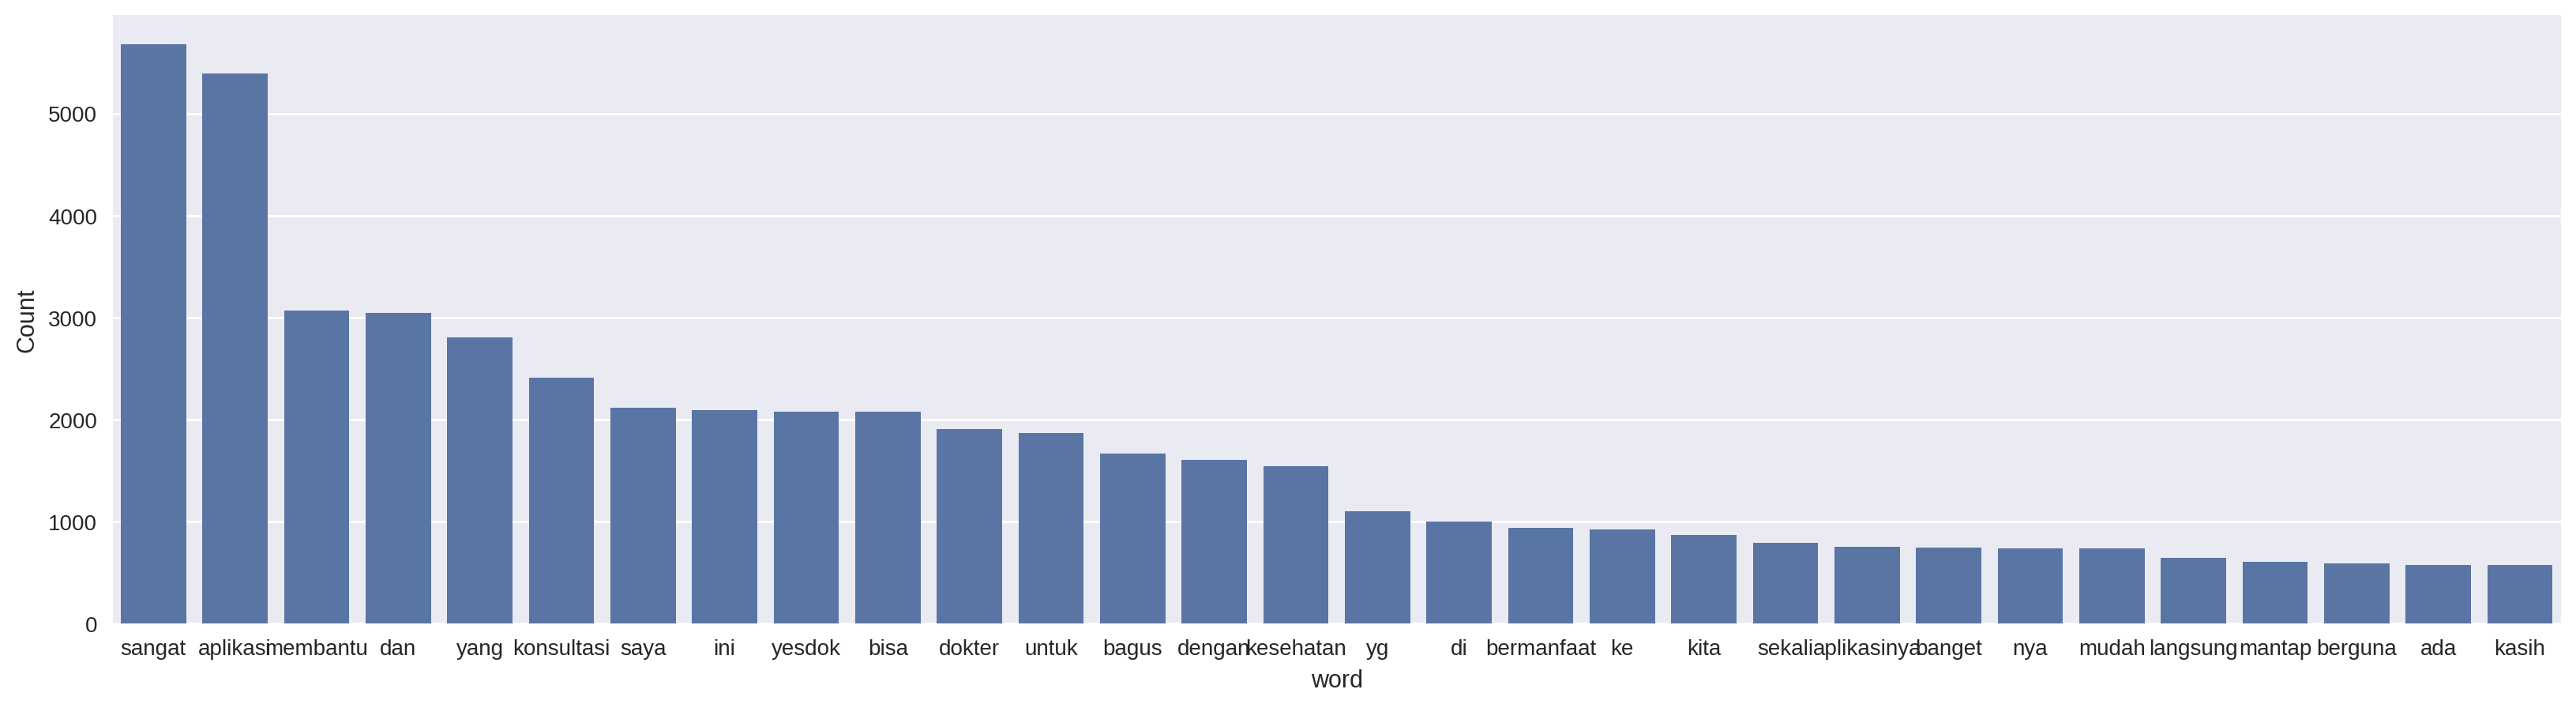

In [ ]:
freq_words(df_yesdokrev_stopwords['tweet_without_stopwords'])

In [ ]:
newStopWords = ["'",".",",", "someone","still","would","need"]

#from nltk.corpus import stopwords
#stoplist = stopwords.words('english') + ['though']


In [ ]:
#Stemming

#Stemming function chops off the end of the word
#and transform the word into its root form.
#All suffixes like -s, -es, -ed, -ing are removed.

def stemming(x):
    st = PorterStemmer()
    if x is not None:
       for word in x.split():
           st.stem(word)

df_yesdokrev_stopwords['tweet_without_stopwords'].apply(lambda x:stemming(x))
print(df_yesdokrev_stopwords['tweet_without_stopwords'][1766])

cara nebus obatnya gimana yh?


In [ ]:
#===BIGRAM https://towardsdatascience.com/text-analysis-basics-in-python-443282942ec5 not yet
#Creating bigram/trigram to search

In [ ]:
#DROP NA
df_yesdokrev_stopwords.dropna(inplace=True)
df_yesdokrev_stopwords.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11676 entries, 0 to 11675
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   content                    11676 non-null  object 
 1   score                      11676 non-null  int64  
 2   sentiment_polarity         11676 non-null  float64
 3   sentiment_subjective       11676 non-null  float64
 4   sentiment_rating           11676 non-null  object 
 5   tweet_without_stopwords    11676 non-null  object 
 6   wordCount                  11676 non-null  int64  
 7   wordCount_after_stopwords  11676 non-null  int64  
dtypes: float64(2), int64(3), object(3)
memory usage: 729.9+ KB


In [ ]:
df_yesdokrev_stopwords.loc[:,["content","score","sentiment_rating","wordCount","tweet_without_stopwords", "wordCount_after_stopwords"]]

,content,score,sentiment_rating,wordCount,tweet_without_stopwords,wordCount_after_stopwords
0,"gak bisa bayar yg mau di bpilih , bingung aneh gak ada bantuan sma sekali",2,Negative,15,"gak bisa bayar yg mau di bpilih , bingung aneh gak ada bantuan sma sekali",15
1,sgt berguna utk tahu kesehatan dan shared soal kesehatan,5,Positive,9,sgt berguna utk tahu kesehatan dan shared soal kesehatan,9
2,sudah war jadwal dokter berbulan2 pas hari h dokternya terkendala jaringan. alhasil uang direfund masuk saldo yesdok dan jika ditf ke rekening ada potongan 10k.. yang rugi siapa di sini ? konsul g...,1,Negative,60,sudah war jadwal dokter berbulan2 pas hari h dokternya terkendala jaringan. alhasil uang direfund masuk saldo yesdok dan jika ditf ke rekening ada potongan 10k.. yang rugi siapa di sini ? konsul g...,60
3,dokternya sibuk terus,1,Negative,3,dokternya sibuk terus,3
4,"aplikasi yang sangat kurang relevan buat dipake karena pelayanan dari pihak yesdok sendiri kurang baik kurang bermanfaat.saya sangat kecewa,marah karena saya sudah transfer lewat bca dan berhasil ...",1,Negative,73,"aplikasi yang sangat kurang relevan buat dipake karena pelayanan dari pihak yesdok sendiri kurang baik kurang bermanfaat.saya sangat kecewa,marah karena saya sudah transfer lewat bca dan berhasil ...",73
...,...,...,...,...,...,...
11671,sangat membantu.. aplikasinya sangat bagus,5,Positive,5,sangat membantu.. aplikasinya sangat bagus,5
11672,sangat membantu dalam konsultasi masalah kesehatan dengan bertatap lngsung pada dokter via vcall,5,Positive,13,sangat membantu dalam konsultasi masalah kesehatan dengan bertatap lngsung pada dokter via vcall,13
11673,bagus,5,Positive,1,bagus,1
11674,helpfully,5,Positive,1,helpfully,1


In [ ]:
# Pastikan kamu sudah mengimpor pandas
import pandas as pd

# Ganti df_yesdokrev_stopwords dengan DataFrame yang ingin kamu simpan
df_yesdokrev_stopwords.loc[:, ["content", "score", "sentiment_rating", "wordCount", "tweet_without_stopwords", "wordCount_after_stopwords"]].to_csv('review_yesdok_stemming.csv', sep=';', index=False)
